In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import random
import pandas as pd
import joblib
import psutil

In [3]:
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [4]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [5]:
print('start read train data...')
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

start read train data...


In [6]:
print('start handle lecture data...')

start handle lecture data...


In [7]:
#reading in lecture df
lectures_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')

In [8]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [9]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [10]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [11]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [12]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [13]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [14]:
#clearing memory
del(train_lectures)
gc.collect()

80

In [15]:
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
user_lecture_agg=user_lecture_agg.astype('int16')

In [16]:
#1= if the event was the user watching a lecture.
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['user_interaction_count'] = cum['cumcount'] 
train_df['user_interaction_timestamp_mean'] = train_df['timestamp']/cum['cumcount'] 
train_df['user_lecture_sum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_sum=train_df.user_lecture_sum.astype('int16')
train_df.user_interaction_count=train_df.user_interaction_count.astype('int16')
train_df['user_interaction_timestamp_mean']=train_df['user_interaction_timestamp_mean']/(1000*3600)
train_df.user_interaction_timestamp_mean=train_df.user_interaction_timestamp_mean.astype('float32')

In [17]:
del cum
gc.collect()

77

In [18]:
print('start handle train_df...')

start handle train_df...


In [19]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

In [20]:
content_explation_agg=train_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])

In [21]:
content_explation_agg.dtypes

mean    float64
dtype: object

In [22]:
content_explation_agg=content_explation_agg.unstack()

content_explation_agg=content_explation_agg.reset_index()
content_explation_agg.columns = ['content_id', 'content_explation_false_mean','content_explation_true_mean']

In [23]:
content_explation_agg.content_id=content_explation_agg.content_id.astype('int16')
content_explation_agg.content_explation_false_mean=content_explation_agg.content_explation_false_mean.astype('float16')
content_explation_agg.content_explation_true_mean=content_explation_agg.content_explation_true_mean.astype('float16')

In [24]:
print('start handle attempt_no...')

start handle attempt_no...


In [25]:

train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
#
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')
#attempt_no_agg=attempt_no_agg.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [26]:
#attempt_no_agg=attempt_no_agg.reset_index()
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]

In [27]:
print('start handle timestamp...')
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

start handle timestamp...


In [28]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
max_timestamp_u.user_id=max_timestamp_u.user_id.astype('int32')

In [29]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()

max_timestamp_u2 = train_df[['user_id','lagtime']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u2.columns = ['user_id', 'max_time_stamp2']
max_timestamp_u2.user_id=max_timestamp_u2.user_id.astype('int32')

In [30]:
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
lagtime_mean=train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)

In [31]:
train_df['lagtime']=train_df['lagtime']/(1000*3600)
train_df.lagtime=train_df.lagtime.astype('float32')

In [32]:
train_df['lagtime2'] = train_df.groupby('user_id')['timestamp'].shift(2)

max_timestamp_u3 = train_df[['user_id','lagtime2']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u3.columns = ['user_id', 'max_time_stamp3']
max_timestamp_u3.user_id=max_timestamp_u3.user_id.astype('int32')

train_df['lagtime2']=train_df['timestamp']-train_df['lagtime2']
lagtime_mean2=train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)

In [33]:
train_df['lagtime2']=train_df['lagtime2']/(1000*3600)
train_df.lagtime2=train_df.lagtime2.astype('float32')

In [34]:
train_df['lagtime3'] = train_df.groupby('user_id')['timestamp'].shift(3)

train_df['lagtime3']=train_df['timestamp']-train_df['lagtime3']
lagtime_mean3=train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)
train_df['lagtime3']=train_df['lagtime3']/(1000*3600)
train_df.lagtime3=train_df.lagtime3.astype('float32')

In [35]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
#
train_df.timestamp=train_df.timestamp.astype('float16')

In [36]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [37]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']

In [38]:
delta_prior_question_elapsed_time_mean=train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [39]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
##cum['cumcount']=cum['cumcount']+1
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)

train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_count'] = cum['cumsum']
train_df['user_uncorrect_count'] = cum['cumcount']-cum['cumsum']
#train_df['user_answer_count'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
train_df['user_correctness'].fillna(0.67, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_count=train_df.user_correct_count.astype('int16')
train_df.user_uncorrect_count=train_df.user_uncorrect_count.astype('int16')
#train_df.user_answer_count=train_df.user_answer_count.astype('int16')

In [40]:
del cum
gc.collect()

20

In [41]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')
# explanation_agg.sum=explanation_agg.sum.astype('int16')
# explanation_agg.count=explanation_agg.count.astype('int16')
#explanation_agg.var=explanation_agg.var.astype('float16')

In [42]:
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum'] 
train_df['explanation_false_count'] =  cum['cumcount']-cum['cumsum']
#train_df.drop(columns=['lag'], inplace=True)

train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_true_count=train_df.explanation_true_count.astype('int16')
train_df.explanation_false_count=train_df.explanation_false_count.astype('int16')

In [43]:
del cum
gc.collect()

73

In [44]:
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [45]:
#
train_df['task_container_uncor_count'] = train_df['task_container_id'].map(task_container_agg['count']-task_container_agg['sum']).astype('int32')
train_df['task_container_cor_count'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [46]:
content_elapsed_time_agg=train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['mean'])
content_had_explanation_agg=train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])

In [47]:
train_df.dtypes

timestamp                            float16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_interaction_count                 int16
user_interaction_timestamp_mean      float32
user_lecture_sum                       int16
user_lecture_lv                      float16
attempt_no                              int8
lagtime                              float32
lagtime2                             float32
lagtime3                             float32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_count                     int16
user_uncorrect_count                   int16
explanation_mean                     float16
explanation_true_count                 int16
explanatio

In [48]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,...,user_correctness,user_correct_count,user_uncorrect_count,explanation_mean,explanation_true_count,explanation_false_count,task_container_uncor_count,task_container_cor_count,task_container_std,task_container_correctness
0,0.000000,115,5692,0,1,1,13005.081055,0,1,0.000000,...,0.669922,0,0,0.0,0,1,187175,208704,0.249268,0.527344
1,0.015823,115,5716,0,2,1,37000.000000,0,2,0.007909,...,1.000000,1,0,0.0,0,2,223198,172342,0.245850,0.435791
2,0.032867,115,128,0,0,1,55000.000000,0,3,0.010960,...,1.000000,2,0,0.0,0,3,126682,269233,0.217651,0.680176
3,0.036438,115,7860,0,3,1,19000.000000,0,4,0.009109,...,1.000000,3,0,0.0,0,4,180574,214721,0.248169,0.542969
4,0.038330,115,7922,0,4,1,11000.000000,0,5,0.007665,...,1.000000,4,0,0.0,0,5,361957,330079,0.249512,0.477051


In [49]:
print('start questions data...')

start questions data...


In [50]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)

In [51]:
bundle_agg = questions_df.groupby('bundle_id')['question_id'].agg(['count'])

In [52]:
questions_df['content_sub_bundle'] = questions_df['bundle_id'].map(bundle_agg['count']).astype('int8')

In [53]:

questions_df['tags'].fillna('188', inplace=True)

In [54]:
def gettags(tags,num):
    tags_splits=tags.split(" ")
    result='' 
    for t in tags_splits:
        x=int(t)
        if(x<32*(num+1) and x>=32*num):#num 
            result=result+' '+t
    return result

In [55]:
from sklearn.preprocessing import LabelEncoder
for num in range(0,6):
    questions_df["tags"+str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags'+str(num)].values))
    #questions_df[['tags'+str(num)]=
    questions_df['tags'+str(num)]=questions_df[['tags'+str(num)]].apply(le.transform)

In [56]:
questions_df_dict = {   
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    #'tags6': 'int8',
    #'tags7': 'int8'
}
questions_df = questions_df.astype(questions_df_dict)

In [57]:
questions_df.drop(columns=['tags'], inplace=True)

In [58]:
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
# tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
# tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
# #

# tag.fillna(0, inplace=True)
# tag = tag.astype('int16')
# questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [59]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [60]:
questions_df = pd.merge(questions_df, content_explation_agg, on='content_id', how='left',right_index=True)#
# questions_df.content_explation_false_mean=questions_df.content_explation_false_mean.astype('float16')
# questions_df.content_explation_true_mean=questions_df.content_explation_true_mean.astype('float16')

In [61]:
del content_explation_agg

In [62]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')
questions_df['content_uncorrect_count'] = questions_df['content_id'].map(content_agg['count']-content_agg['sum']).astype('int32')
questions_df['content_correct_count'] = questions_df['content_id'].map(content_agg['sum']).astype('int32')

In [63]:
questions_df['content_elapsed_time_mean'] = questions_df['content_id'].map(content_elapsed_time_agg['mean'])
questions_df.content_elapsed_time_mean=questions_df.content_elapsed_time_mean.astype('float16')
questions_df['content_had_explanation_mean'] = questions_df['content_id'].map(content_had_explanation_agg['mean'])
questions_df.content_had_explanation_mean=questions_df.content_had_explanation_mean.astype('float16')

In [64]:
del content_elapsed_time_agg
del content_had_explanation_agg
gc.collect()

193

In [65]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [66]:
part_agg = questions_df.groupby('part')['content_uncorrect_count'].agg(['sum'])
questions_df['part_uncor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')
#
part_agg = questions_df.groupby('part')['content_correct_count'].agg(['sum'])
questions_df['part_cor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')

In [67]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness_mean'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness_mean=questions_df.bundle_correctness_mean.astype('float16')

# bundle_agg = questions_df.groupby('bundle_id')['content_uncorrect_count'].agg(['sum'])
# questions_df['bundle_uncor_count'] = questions_df['bundle_id'].map(bundle_agg['sum']).astype('int32')
# #
# bundle_agg = questions_df.groupby('bundle_id')['content_correct_count'].agg(['sum'])
# questions_df['bundle_cor_count'] = questions_df['bundle_id'].map(bundle_agg['sum']).astype('int32')

In [68]:
questions_df.dtypes

content_id                        int16
bundle_id                         int16
part                               int8
content_sub_bundle                 int8
tags0                              int8
tags1                              int8
tags2                              int8
tags3                              int8
tags4                              int8
tags5                              int8
part_bundle_id                    int32
content_explation_false_mean    float16
content_explation_true_mean     float16
content_correctness             float16
content_correctness_std         float16
content_uncorrect_count           int32
content_correct_count             int32
content_elapsed_time_mean       float16
content_had_explanation_mean    float16
part_correctness_mean           float16
part_correctness_std            float16
part_uncor_count                  int32
part_cor_count                    int32
bundle_correctness_mean         float16
dtype: object

In [69]:
del content_agg
del bundle_agg
del part_agg
#del tags1_agg
gc.collect()

100

In [70]:
len(train_df)

99271300

# Train

In [71]:
features_dict = {
    #'user_id',
    'timestamp':'float16',#
    'user_interaction_count':'int16',
    'user_interaction_timestamp_mean':'float32',
    'lagtime':'float32',#
    'lagtime2':'float32',
    'lagtime3':'float32',
    #'lagtime_mean':'int32',
    'content_id':'int16',
    'task_container_id':'int16',
    'user_lecture_sum':'int16',#
    'user_lecture_lv':'float16',##
    'prior_question_elapsed_time':'float32',#
    'delta_prior_question_elapsed_time':'int32',#
    'user_correctness':'float16',#
    'user_uncorrect_count':'int16',#
    'user_correct_count':'int16',#
    #'content_correctness':'float16',
    'content_correctness_std':'float16',
    'content_correct_count':'int32',
    'content_uncorrect_count':'int32',#
    'content_elapsed_time_mean':'float16',
    'content_had_explanation_mean':'float16',
    'content_explation_false_mean':'float16',
    'content_explation_true_mean':'float16',
    'task_container_correctness':'float16',
    'task_container_std':'float16',
    'task_container_cor_count':'int32',#
    'task_container_uncor_count':'int32',#
    'attempt_no':'int8',#
    'part':'int8',
    'part_correctness_mean':'float16',
    'part_correctness_std':'float16',
    'part_uncor_count':'int32',
    'part_cor_count':'int32',
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
   # 'tags6': 'int8',
   # 'tags7': 'int8',
#     'tags0_correctness_mean':'float16',
#     'tags1_correctness_mean':'float16',
#     'tags2_correctness_mean':'float16',
#     'tags4_correctness_mean':'float16',
#     'bundle_id':'int16',
#     'bundle_correctness_mean':'float16',
#     'bundle_uncor_count':'int32',
#     'bundle_cor_count':'int32',
    'part_bundle_id':'int32',
    'content_sub_bundle':'int8',
    'prior_question_had_explanation':'int8',
    'explanation_mean':'float16', #
    #'explanation_var',#
    'explanation_false_count':'int16',#
    'explanation_true_count':'int16',#
   # 'community':'int8',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
}
categorical_columns= [
    #'user_id',
    'content_id',
    'task_container_id',
    'part',
   # 'community',
    'tags0',
    'tags1',
    'tags2',
    'tags3',
    'tags4',
    'tags5',
    #'tags6',
    #'tags7',
    #'bundle_id',
    'part_bundle_id',
    'content_sub_bundle',
    'prior_question_had_explanation', 
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]

features=list(features_dict.keys())


In [72]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 200,
'max_bin':450,
# 'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
#'min_data_in_leaf': 106,
# 'max_depth': -1,
'objective': 'binary',
'learning_rate': 0.05,
"boosting_type": "gbdt",
"metric": 'auc',
# "bagging_seed": 11,
# "verbosity": -1,
# 'reg_alpha': 0.3899927210061127,
# 'reg_lambda': 0.6485237330340494,
# 'random_state': 47
}
trains=list()
valids=list()
num=1
for i in range(0,num):
    
    #train_df=train_df.reset_index(drop=True)
    #train_df_clf=train_df.sample(n=1200*10000)
    train_df_clf=train_df[1200*10000:2*1200*10000]
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    del train_df
    
    
    
    users=train_df_clf['user_id'].drop_duplicates()#
    #
    users=users.sample(frac=0.08)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
   
   
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
    print('pd.merge(train_df_clf, questions_df)')
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)
    print('valid_df')
    valid_df=train_df_clf.sample(frac=0.1)
    train_df_clf.drop(valid_df.index, inplace=True)
    
#     test_df=train_df_clf.sample(n=100*10000)
#     train_df_clf.drop(test_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('train_df_clf length：',len(train_df_clf))
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
pd.merge(train_df_clf, questions_df)
valid_df
train_df_clf length： 9979258
valid_df length： 2020742


In [73]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

20

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['content_id', 'content_sub_bundle', 'part', 'part_bundle_id', 'prior_question_had_explanation', 'tags0', 'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'task_container_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.771229	valid_1's auc: 0.766447
[100]	training's auc: 0.78131	valid_1's auc: 0.770863
[150]	training's auc: 0.788258	valid_1's auc: 0.772763
[200]	training's auc: 0.793607	valid_1's auc: 0.773619
[250]	training's auc: 0.797384	valid_1's auc: 0.774023
[300]	training's auc: 0.800461	valid_1's auc: 0.774238
[350]	training's auc: 0.803233	valid_1's auc: 0.774246
Early stopping, best iteration is:
[307]	training's auc: 0.800855	valid_1's auc: 0.774297


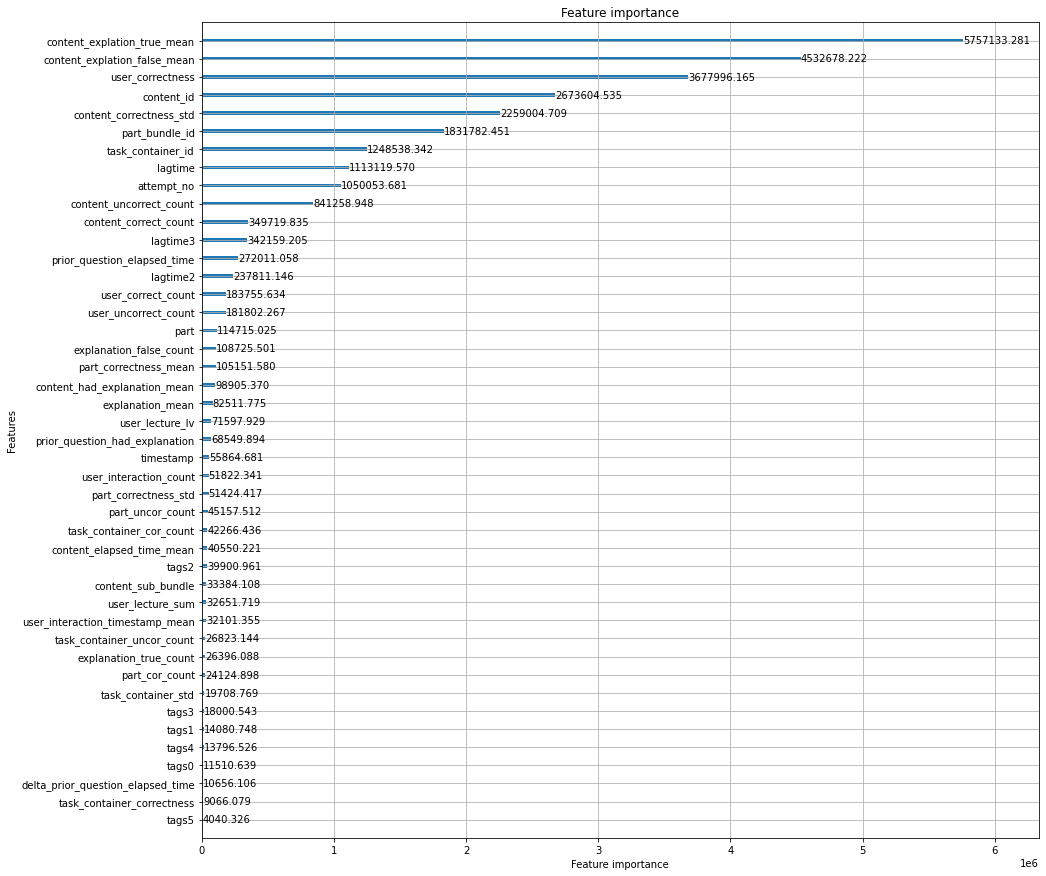

In [74]:
for i in range(0,num):
      
#     tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
#     va_data = lgb.Dataset(valids[i][features], label=valids[i][target])

    #Don't use DF to create lightgbm dataset, rather use np array:
    X_train_np = trains[i][features].values.astype(np.float32)
    X_valid_np = valids[i][features].values.astype(np.float32)
    #features = train.columns
    tr_data = lgb.Dataset(X_train_np, label=trains[i][target], feature_name=list(features))
    va_data = lgb.Dataset(X_valid_np, label=valids[i][target], feature_name=list(features))
    

#     del train_df_clf
#     del valid_df
#     gc.collect()
    del trains
    del valids
    del X_train_np
    del X_valid_np
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=5000,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    clfs.append(model)
    #print('test-auc:', roc_auc_score(test_df[target], model.predict(test_df[features])))
    #model.save_model(f'model.txt')


    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show()

    del tr_data
    del va_data
    gc.collect()
#    
# del trains
# del valids
# gc.collect()
# del test_df
# gc.collect()

# Transformer

In [75]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

MAX_SEQ = 240 # 210
EMBED_SIZE = 256 # 256
DROPOUT = 0.1 # 0.1

class FFN(nn.Module):
    def __init__(self, state_size = 200, forward_expansion = 1, bn_size = MAX_SEQ - 1, dropout=0.2):
        super(FFN, self).__init__()
        self.state_size = state_size
        
        self.lr1 = nn.Linear(state_size, forward_expansion * state_size)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(bn_size)
        self.lr2 = nn.Linear(forward_expansion * state_size, state_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.relu(self.lr1(x))
        x = self.bn(x)
        x = self.lr2(x)
        return self.dropout(x)
    
class FFN0(nn.Module):
    def __init__(self, state_size = 200, forward_expansion = 1, bn_size = MAX_SEQ - 1, dropout=0.2):
        super(FFN0, self).__init__()
        self.state_size = state_size

        self.lr1 = nn.Linear(state_size, forward_expansion * state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(forward_expansion * state_size, state_size)
        self.layer_normal = nn.LayerNorm(state_size) 
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        x=self.layer_normal(x)
        return self.dropout(x)

    
def future_mask(seq_length):
    future_mask = (np.triu(np.ones([seq_length, seq_length]), k = 1)).astype('bool')
    return torch.from_numpy(future_mask)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads = 8, dropout = DROPOUT, forward_expansion = 1):
        super(TransformerBlock, self).__init__()
        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_normal = nn.LayerNorm(embed_dim)
        self.ffn = FFN(embed_dim, forward_expansion = forward_expansion, dropout=dropout)
        self.ffn0  = FFN0(embed_dim, forward_expansion = forward_expansion, dropout=dropout)
        self.layer_normal_2 = nn.LayerNorm(embed_dim)

    def forward(self, value, key, query, att_mask):
        att_output, att_weight = self.multi_att(value, key, query, attn_mask=att_mask)
        att_output = self.dropout(self.layer_normal(att_output + value))
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]
        x = self.ffn(att_output)
        x1 = self.ffn0(att_output)
        x = self.dropout(self.layer_normal_2(x + x1 + att_output))
        return x.squeeze(-1), att_weight
    
class Encoder(nn.Module):
    def __init__(self, n_skill, max_seq=100, embed_dim=128, dropout = DROPOUT, forward_expansion = 1, num_layers=1, heads = 8):
        super(Encoder, self).__init__()
        self.n_skill, self.embed_dim = n_skill, embed_dim
        self.embedding = nn.Embedding(2 * n_skill + 1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq - 1, embed_dim)
        self.e_embedding = nn.Embedding(n_skill+1, embed_dim)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, forward_expansion = forward_expansion) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, question_ids):
        device = x.device
        x = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        pos_x = self.pos_embedding(pos_id)
        x = self.dropout(x + pos_x)
        x = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e = self.e_embedding(question_ids)
        e = e.permute(1, 0, 2)
        for layer in self.layers:
            att_mask = future_mask(e.size(0)).to(device)
            x, att_weight = layer(e, x, x, att_mask=att_mask)
            x = x.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        return x, att_weight

class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=100, embed_dim=128, dropout = DROPOUT, forward_expansion = 1, enc_layers=1, heads = 8):
        super(SAKTModel, self).__init__()
        self.encoder = Encoder(n_skill, max_seq, embed_dim, dropout, forward_expansion, num_layers=enc_layers)
        self.pred = nn.Linear(embed_dim, 1)
        
    def forward(self, x, question_ids):
        x, att_weight = self.encoder(x, question_ids)
        x = self.pred(x)
        return x.squeeze(-1), att_weight

n_skill = joblib.load("../input/riiid-data/n_skill.pkl")
group = joblib.load("../input/riiid-data/group.pkl")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model = SAKTModel(n_skill, max_seq=MAX_SEQ, embed_dim=EMBED_SIZE, forward_expansion=1, enc_layers=1, heads=8, dropout=0.1)

try:
    nn_model.load_state_dict(torch.load("../input/transformer2ffn/sakt_8.pth"))
except:
    nn_model.load_state_dict(torch.load("../input/transformer2ffn/sakt_8.pth", map_location='cpu'))
nn_model.to(device)
nn_model.eval()

SAKTModel(
  (encoder): Encoder(
    (embedding): Embedding(27047, 256)
    (pos_embedding): Embedding(239, 256)
    (e_embedding): Embedding(13524, 256)
    (layers): ModuleList(
      (0): TransformerBlock(
        (multi_att): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_normal): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN(
          (lr1): Linear(in_features=256, out_features=256, bias=True)
          (relu): ReLU()
          (bn): BatchNorm1d(239, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lr2): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn0): FFN0(
          (lr1): Linear(in_features=256, out_features=256, bias=True)
          (relu): ReLU()
          (lr2): Linear(in_features=256, out_features=256, bias=True)

# Inference

In [76]:
class TestDataset(Dataset):
    def __init__(self, samples, test_df, n_skill, max_seq=100):
        super(TestDataset, self).__init__()
        self.samples, self.user_ids, self.test_df = samples, [x for x in test_df["user_id"].unique()], test_df
        self.n_skill, self.max_seq = n_skill, max_seq

    def __len__(self):
        return self.test_df.shape[0]
    
    def __getitem__(self, index):
        test_info = self.test_df.iloc[index]
        
        user_id = test_info['user_id']
        target_id = test_info['content_id']
        
        content_id_seq = np.zeros(self.max_seq, dtype=int)
        answered_correctly_seq = np.zeros(self.max_seq, dtype=int)
        
        if user_id in self.samples.index:
            content_id, answered_correctly = self.samples[user_id]
            
            seq_len = len(content_id)
            
            if seq_len >= self.max_seq:
                content_id_seq = content_id[-self.max_seq:]
                answered_correctly_seq = answered_correctly[-self.max_seq:]
            else:
                content_id_seq[-seq_len:] = content_id
                answered_correctly_seq[-seq_len:] = answered_correctly
                
        x = content_id_seq[1:].copy()
        x += (answered_correctly_seq[1:] == 1) * self.n_skill
        
        questions = np.append(content_id_seq[2:], [target_id])
        
        return x, questions

In [77]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
# user_sum_dict2 = user_agg2['sum'].astype('int16').to_dict(defaultdict(int))
# user_count_dict2 = user_agg2['count'].astype('int16').to_dict(defaultdict(int))

In [78]:
#user_var_dict = user_agg['var'].astype('float16').to_dict(defaultdict(int))

# content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
# content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

del user_agg
#del user_agg2
#del content_agg
gc.collect()

task_container_sum_dict = task_container_agg['sum'].astype('int32').to_dict(defaultdict(int))
task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(int))

explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))
#explanation_var_dict = explanation_agg['var'].astype('float16').to_dict(defaultdict(int))
del task_container_agg
del explanation_agg
gc.collect()

0

In [79]:
user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))

#lagtime_mean_dict = lagtime_agg['mean'].astype('int32').to_dict(defaultdict(int))
#del prior_question_elapsed_time_agg
del user_lecture_agg
#del lagtime_agg
gc.collect()

20

In [80]:
max_timestamp_u_dict=max_timestamp_u.set_index('user_id').to_dict()
max_timestamp_u_dict2=max_timestamp_u2.set_index('user_id').to_dict()
max_timestamp_u_dict3=max_timestamp_u3.set_index('user_id').to_dict()
user_prior_question_elapsed_time_dict=user_prior_question_elapsed_time.set_index('user_id').to_dict()
#del question_elapsed_time_agg
del max_timestamp_u
del max_timestamp_u2
del max_timestamp_u3
del user_prior_question_elapsed_time
gc.collect()

20

In [81]:
attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))

del attempt_no_agg
gc.collect()

0

In [82]:
def get_max_attempt(user_id,content_id):
    k = (user_id,content_id)

    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]

    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]

In [83]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()

In [84]:
iter_test = env.iter_test()
prior_test_df = None
prev_test_df1 = None

In [85]:
# N=[0.4,0.6]

In [86]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    test_df1=test_df.copy()
    if (prev_test_df1 is not None):
        prev_test_df1['answered_correctly'] = eval(test_df1['prior_group_answers_correct'].iloc[0])
        prev_test_df1 = prev_test_df1[prev_test_df1.content_type_id == False]
        
        prev_group = prev_test_df1[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))
        for prev_user_id in prev_group.index:
            if prev_user_id in group.index:
                group[prev_user_id] = (
                    np.append(group[prev_user_id][0], prev_group[prev_user_id][0])[-MAX_SEQ:], 
                    np.append(group[prev_user_id][1], prev_group[prev_user_id][1])[-MAX_SEQ:]
                )
 
            else:
                group[prev_user_id] = (
                    prev_group[prev_user_id][0], 
                    prev_group[prev_user_id][1]
                )
        #HDKIMHDKIM
        
    #HDKIM
    prev_test_df1 = test_df1.copy()
    
    test_df1 = test_df1[test_df1.content_type_id == False]
    test_dataset = TestDataset(group, test_df1, n_skill, max_seq=MAX_SEQ)
    test_dataloader = DataLoader(test_dataset, batch_size=51200, shuffle=False)
    
    outs = []

    for item in test_dataloader:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()
        with torch.no_grad():
            output, att_weight = nn_model(x, target_id)
        outs.extend(torch.sigmoid(output)[:, -1].view(-1).data.cpu().numpy())
    
    #test_df1['answered_correctly'] = outs
    #HDKIM
    
    ###for lgb
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        #prior_test_df = prior_test_df[prior_test_df[target] != -1]
        prior_test_df['prior_question_had_explanation'].fillna(False, inplace=True)       
        prior_test_df.prior_question_had_explanation=prior_test_df.prior_question_had_explanation.astype('int8')
    
        user_ids = prior_test_df['user_id'].values
        #content_ids = prior_test_df['content_id'].values
        #task_container_ids = prior_test_df['task_container_id'].values
        #prior_question_had_explanations = prior_test_df['prior_question_had_explanation'].values
        targets = prior_test_df[target].values        
        
        for user_id, answered_correctly in zip(user_ids,targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
#             user_sum_dict2[user_id] += answered_correctly
#             user_count_dict2[user_id] += 1   
            

    prior_test_df = test_df.copy() 
        
    
    question_len=len( test_df[test_df['content_type_id'] == 0])
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.prior_question_had_explanation=test_df.prior_question_had_explanation.astype('int8')
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    

    user_lecture_sum = np.zeros(question_len, dtype=np.int16)
    user_lecture_count = np.zeros(question_len, dtype=np.int16) 
    
    user_sum = np.zeros(question_len, dtype=np.int16)
    user_count = np.zeros(question_len, dtype=np.int16)
#     user_sum2 = np.zeros(question_len, dtype=np.int16)
#     user_count2 = np.zeros(question_len, dtype=np.int16)

#     user_sum_dict_test=defaultdict(int)
#     user_count_dict_test=defaultdict(int)

    task_container_sum = np.zeros(question_len, dtype=np.int32)
    task_container_count = np.zeros(question_len, dtype=np.int32)
    task_container_std = np.zeros(question_len, dtype=np.float16)

    explanation_sum = np.zeros(question_len, dtype=np.int32)
    explanation_count = np.zeros(question_len, dtype=np.int32)
    delta_prior_question_elapsed_time = np.zeros(question_len, dtype=np.int32)

    attempt_no_count = np.zeros(question_len, dtype=np.int16)
    lagtime = np.zeros(question_len, dtype=np.float32)
    lagtime2 = np.zeros(question_len, dtype=np.float32)
    lagtime3 = np.zeros(question_len, dtype=np.float32)
    #lagtime_means = np.zeros(question_len, dtype=np.int32)
    #
   
    i=0
    for j, (user_id,prior_question_had_explanation,content_type_id,prior_question_elapsed_time,timestamp, content_id,task_container_id) in enumerate(zip(test_df['user_id'].values,test_df['prior_question_had_explanation'].values,test_df['content_type_id'].values,test_df['prior_question_elapsed_time'].values,test_df['timestamp'].values, test_df['content_id'].values, test_df['task_container_id'].values)):
        
         #
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        if(content_type_id==1):#
            x=1
#             if(len(user_lecture_stats_part[user_lecture_stats_part.user_id==user_id])==0):
#                 user_lecture_stats_part = user_lecture_stats_part.append([{'user_id':user_id}], ignore_index=True)
#                 user_lecture_stats_part.fillna(0, inplace=True)
#                 user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
#             else:
#                 user_lecture_stats_part.loc[user_lecture_stats_part.user_id==user_id,part_lectures_columns + types_of_lectures_columns]+=lectures_df[lectures_df.lecture_id==content_id][part_lectures_columns + types_of_lectures_columns].values
        if(content_type_id==0):#   
            user_lecture_sum[i] = user_lecture_sum_dict[user_id]
            user_lecture_count[i] = user_lecture_count_dict[user_id]
                
            user_sum[i] = user_sum_dict[user_id]
            user_count[i] = user_count_dict[user_id]
#             user_sum2[i] = user_sum_dict2[user_id]
#             user_count2[i] = user_count_dict2[user_id]
    #         content_sum[i] = content_sum_dict[content_id]
    #         content_count[i] = content_count_dict[content_id]
            task_container_sum[i] = task_container_sum_dict[task_container_id]
            task_container_count[i] = task_container_count_dict[task_container_id]
            task_container_std[i]=task_container_std_dict[task_container_id]

            explanation_sum_dict[user_id] += prior_question_had_explanation
            explanation_count_dict[user_id] += 1
            explanation_sum[i] = explanation_sum_dict[user_id]
            explanation_count[i] = explanation_count_dict[user_id]

            if user_id in max_timestamp_u_dict['max_time_stamp'].keys():
                lagtime[i]=timestamp-max_timestamp_u_dict['max_time_stamp'][user_id]
                if(max_timestamp_u_dict2['max_time_stamp2'][user_id]==lagtime_mean2):#
                    lagtime2[i]=lagtime_mean2
                    lagtime3[i]=lagtime_mean3
                    #max_timestamp_u_dict3['max_time_stamp3'].update({user_id:lagtime_mean3})
                else:
                    lagtime2[i]=timestamp-max_timestamp_u_dict2['max_time_stamp2'][user_id]
                    if(max_timestamp_u_dict3['max_time_stamp3'][user_id]==lagtime_mean3):
                        lagtime3[i]=lagtime_mean3 #
                    else:
                        lagtime3[i]=timestamp-max_timestamp_u_dict3['max_time_stamp3'][user_id]
                    
                    max_timestamp_u_dict3['max_time_stamp3'][user_id]=max_timestamp_u_dict2['max_time_stamp2'][user_id]
                        
                max_timestamp_u_dict2['max_time_stamp2'][user_id]=max_timestamp_u_dict['max_time_stamp'][user_id]
                max_timestamp_u_dict['max_time_stamp'][user_id]=timestamp
#                 lagtime_means[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2
#                 lagtime_mean_dict[user_id]=lagtime_means[i]
            else:
                lagtime[i]=lagtime_mean
                max_timestamp_u_dict['max_time_stamp'].update({user_id:timestamp})
                lagtime2[i]=lagtime_mean2#
                max_timestamp_u_dict2['max_time_stamp2'].update({user_id:lagtime_mean2})
                lagtime3[i]=lagtime_mean3#
                max_timestamp_u_dict3['max_time_stamp3'].update({user_id:lagtime_mean3})
#                 lagtime_mean_dict.update({user_id:lagtime_mean})
#                 lagtime_means[i]=(lagtime_mean_dict[user_id]+lagtime[i])/2

            if user_id in user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].keys():            
                delta_prior_question_elapsed_time[i]=prior_question_elapsed_time-user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]
                user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]=prior_question_elapsed_time
            else:           
                delta_prior_question_elapsed_time[i]=delta_prior_question_elapsed_time_mean    
                user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].update({user_id:prior_question_elapsed_time})
            i=i+1 


        
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    #test_df = test_df[test_df['content_type_id'] == 0]
    #right_index=True
    #test_df = pd.merge(test_df, questions_df, on='content_id', how='left',right_index=True)    
    #test_df = pd.concat([test_df.reset_index(drop=True), questions_df.reindex(test_df['content_id'].values).reset_index(drop=True)], axis=1)
    test_df=test_df.merge(questions_df.loc[questions_df.index.isin(test_df['content_id'])],
                  how='left', on='content_id', right_index=True)
    
    #test_df = pd.merge(test_df, user_lecture_stats_part, on=['user_id'], how="left",right_index=True)
    #test_df = pd.concat([test_df.reset_index(drop=True), user_lecture_stats_part.reindex(test_df['user_id'].values).reset_index(drop=True)], axis=1)
#     test_df=test_df.merge(user_lecture_stats_part.loc[user_lecture_stats_part.index.isin(test_df['user_id'])],
#                   how='left', on='user_id', right_index=True)
 
    test_df['user_lecture_lv'] = user_lecture_sum / user_lecture_count
    test_df['user_lecture_sum'] = user_lecture_sum
    
    test_df['user_interaction_count'] = user_lecture_count
    test_df['user_interaction_timestamp_mean'] = test_df['timestamp']/user_lecture_count
    
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_uncorrect_count'] =user_count-user_sum
    test_df['user_correct_count'] =user_sum
    #test_df['user_answer_count'] =user_count
    
#     test_df['user_correctness2'] = user_sum2 / user_count2
#     test_df['user_uncorrect_count2'] =user_count2-user_sum2
#     test_df['user_correct_count2'] =user_sum2
    #test_df['user_answer_count2'] =user_count2
    
    #    
    test_df['task_container_correctness'] = task_container_sum / task_container_count
    test_df['task_container_cor_count'] = task_container_sum 
    test_df['task_container_uncor_count'] =task_container_count-task_container_sum 
    test_df['task_container_std'] = task_container_std 
    #test_df['content_task_mean'] = content_task_mean 
    
    test_df['explanation_mean'] = explanation_sum / explanation_count
    test_df['explanation_true_count'] = explanation_sum
    test_df['explanation_false_count'] = explanation_count-explanation_sum 
    
    #
    test_df['delta_prior_question_elapsed_time'] = delta_prior_question_elapsed_time 
    
  
 
    test_df["attempt_no"] = test_df[["user_id", "content_id"]].apply(lambda row: get_max_attempt(row["user_id"], row["content_id"]), axis=1)
    test_df["lagtime"]=lagtime
    test_df["lagtime2"]=lagtime2
    test_df["lagtime3"]=lagtime3
    #test_df["lagtime_mean"]=lagtime_means

    

    test_df['timestamp']=test_df['timestamp']/(1000*3600)
    test_df.timestamp=test_df.timestamp.astype('float16')
    test_df['lagtime']=test_df['lagtime']/(1000*3600)
    test_df.lagtime=test_df.lagtime.astype('float32')
    test_df['lagtime2']=test_df['lagtime2']/(1000*3600)
    test_df.lagtime2=test_df.lagtime2.astype('float32')
    test_df['lagtime3']=test_df['lagtime3']/(1000*3600)
    test_df.lagtime3=test_df.lagtime3.astype('float32')
    test_df['user_interaction_timestamp_mean']=test_df['user_interaction_timestamp_mean']/(1000*3600)
    test_df.user_interaction_timestamp_mean=test_df.user_interaction_timestamp_mean.astype('float32')
    
    test_df['user_correctness'].fillna(0.67, inplace=True)
    #test_df['user_correctness2'].fillna(0.67, inplace=True)
    #
    #test_df = test_df.astype(features_dict)

    sub_preds = np.zeros(test_df.shape[0])
    for i, model in enumerate(clfs, 1):
        test_preds  = model.predict(test_df[features])
        sub_preds += test_preds
    o2=sub_preds / len(clfs)
    
    test_df[target]=0.5*np.array(outs)+0.5*np.array(o2)
#     if(flag_lgbm):
#         test_df[target] = model.predict(test_df[features])
#     else:
#         test_df[target] = model.predict(test_df[features].values)
    env.predict(test_df[['row_id', target]])

CPU times: user 3.39 s, sys: 204 ms, total: 3.6 s
Wall time: 2.22 s
